In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

/tmp/ipykernel_89463/822992949.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-15 15:34:45.104329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 15:34:45.139050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 15:34:

In [2]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=100

In [6]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's use the GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [7]:
nepochs=200

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

CUDA is available. Using GPU.
Epoch 1


Batch number:   0%|          | 0/1805 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [28]:
preds = model.predict(X_test.to_numpy())

In [29]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.004214362635480373

In [30]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

28.44157218983968

In [31]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.21093333333333333

## Visualise

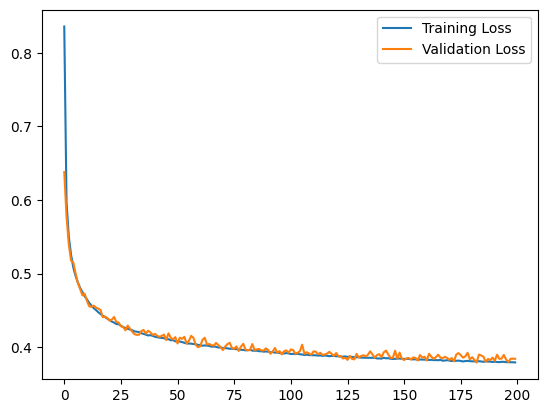

In [32]:
plt.plot(model.train_loss)
plt.plot(model.val_loss)
plt.legend(['Training Loss','Validation Loss'])

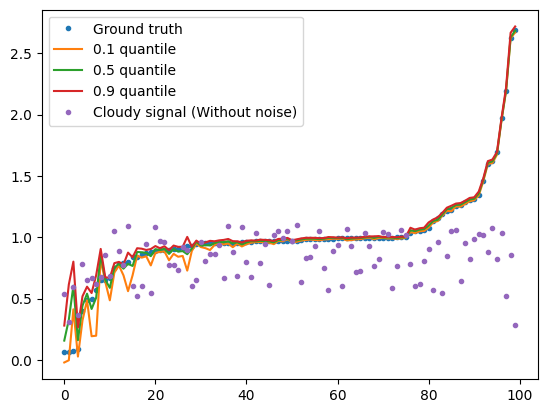

In [33]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


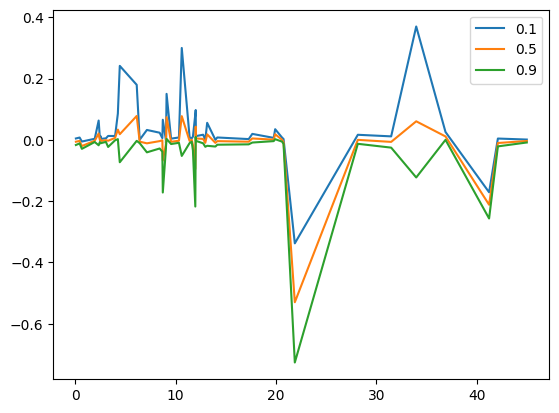

In [34]:
channel=5
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

In [35]:
hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)

## Test multiple runs

In [47]:
num_epochs=[10,20]

sequential_models=[ 
lambda: nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels))
),
lambda: nn.Sequential(
    nn.Linear(len(X_labels),128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128, len(quantiles)*len(y_labels))
)]

In [48]:
sequential_models[0]

<function __main__.<lambda>()>

In [49]:
for nepochs in num_epochs:
    for i,sequantial in enumerate(sequential_models):
        
        model=QuantileNetwork(quantiles=quantiles)
        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequantial())
        
        hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs_'+'network_index_'+str(i),
                                    model=model,X_test=X_test,y_test=y_test)
        
                

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 378.62it/s]


Training loss [0.83696735] Validation loss [0.63547623]
----New best validation loss---- [0.63547623]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 379.59it/s]


Training loss [0.5936159] Validation loss [0.5662661]
----New best validation loss---- [0.5662661]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 367.38it/s]

Training loss [0.54953486] Validation loss [0.53734994]
----New best validation loss---- [0.53734994]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.23it/s]


Training loss [0.5261939] Validation loss [0.51872796]
----New best validation loss---- [0.51872796]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.82it/s]


Training loss [0.5097564] Validation loss [0.50228703]
----New best validation loss---- [0.50228703]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.73it/s]


Training loss [0.49633154] Validation loss [0.49053398]
----New best validation loss---- [0.49053398]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.14it/s]


Training loss [0.48624393] Validation loss [0.48696437]
----New best validation loss---- [0.48696437]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.10it/s]


Training loss [0.47754085] Validation loss [0.48830155]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 345.14it/s]


Training loss [0.47239843] Validation loss [0.4767115]
----New best validation loss---- [0.4767115]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.93it/s]


Training loss [0.46582168] Validation loss [0.47120282]
----New best validation loss---- [0.47120282]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.00it/s]


Training loss [0.74710727] Validation loss [0.59853846]
----New best validation loss---- [0.59853846]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.74it/s]


Training loss [0.5416226] Validation loss [0.51338124]
----New best validation loss---- [0.51338124]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.91it/s]


Training loss [0.5015558] Validation loss [0.49200144]
----New best validation loss---- [0.49200144]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.77it/s]


Training loss [0.47958708] Validation loss [0.46688986]
----New best validation loss---- [0.46688986]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.18it/s]


Training loss [0.46413198] Validation loss [0.46099007]
----New best validation loss---- [0.46099007]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.95it/s]


Training loss [0.4538667] Validation loss [0.44907513]
----New best validation loss---- [0.44907513]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.22it/s]


Training loss [0.44544902] Validation loss [0.43793103]
----New best validation loss---- [0.43793103]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.86it/s]


Training loss [0.43889317] Validation loss [0.43681064]
----New best validation loss---- [0.43681064]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.69it/s]


Training loss [0.43285266] Validation loss [0.43163306]
----New best validation loss---- [0.43163306]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.02it/s]


Training loss [0.42831337] Validation loss [0.4289991]
----New best validation loss---- [0.4289991]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 338.28it/s]


Training loss [0.8289272] Validation loss [0.6278596]
----New best validation loss---- [0.6278596]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.51it/s]


Training loss [0.59013146] Validation loss [0.5670168]
----New best validation loss---- [0.5670168]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.52it/s]

Training loss [0.54374343] Validation loss [0.52804935]
----New best validation loss---- [0.52804935]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.86it/s]


Training loss [0.51911163] Validation loss [0.5064952]
----New best validation loss---- [0.5064952]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.59it/s]

Training loss [0.50237507] Validation loss [0.4985021]
----New best validation loss---- [0.4985021]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 325.63it/s]


Training loss [0.4897616] Validation loss [0.48198858]
----New best validation loss---- [0.48198858]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.76it/s]


Training loss [0.47965378] Validation loss [0.4759047]
----New best validation loss---- [0.4759047]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.16it/s]


Training loss [0.4725613] Validation loss [0.4704416]
----New best validation loss---- [0.4704416]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.80it/s]


Training loss [0.4669337] Validation loss [0.4686748]
----New best validation loss---- [0.4686748]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.81it/s]


Training loss [0.46178782] Validation loss [0.46135437]
----New best validation loss---- [0.46135437]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]

Training loss [0.45694506] Validation loss [0.46262273]
Epoch 12



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 342.91it/s]


Training loss [0.45339295] Validation loss [0.4603163]
----New best validation loss---- [0.4603163]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.14it/s]

Training loss [0.45014533] Validation loss [0.45136273]
----New best validation loss---- [0.45136273]
Epoch 14



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.00it/s]


Training loss [0.44666174] Validation loss [0.44615167]
----New best validation loss---- [0.44615167]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.28it/s]


Training loss [0.44378883] Validation loss [0.45222077]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.28it/s]


Training loss [0.4417707] Validation loss [0.4412019]
----New best validation loss---- [0.4412019]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 344.93it/s]


Training loss [0.43858215] Validation loss [0.44448686]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]


Training loss [0.43712544] Validation loss [0.43949503]
----New best validation loss---- [0.43949503]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.32it/s]

Training loss [0.43471697] Validation loss [0.43649763]
----New best validation loss---- [0.43649763]
Epoch 20



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.94it/s]


Training loss [0.43274269] Validation loss [0.43574896]
----New best validation loss---- [0.43574896]
Best model out of total max epochs found at epoch 20
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.81it/s]


Training loss [0.75236434] Validation loss [0.578092]
----New best validation loss---- [0.578092]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 253.53it/s]


Training loss [0.54224783] Validation loss [0.51310426]
----New best validation loss---- [0.51310426]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.91it/s]


Training loss [0.49883968] Validation loss [0.4763381]
----New best validation loss---- [0.4763381]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.40it/s]


Training loss [0.4747396] Validation loss [0.4631469]
----New best validation loss---- [0.4631469]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.32it/s]


Training loss [0.45809036] Validation loss [0.456204]
----New best validation loss---- [0.456204]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.29it/s]


Training loss [0.44690385] Validation loss [0.44528773]
----New best validation loss---- [0.44528773]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.96it/s]


Training loss [0.43831152] Validation loss [0.4353292]
----New best validation loss---- [0.4353292]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.17it/s]

Training loss [0.43105376] Validation loss [0.42888376]


----New best validation loss---- [0.42888376]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.79it/s]


Training loss [0.42516756] Validation loss [0.41713938]
----New best validation loss---- [0.41713938]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.25it/s]


Training loss [0.41991258] Validation loss [0.42020005]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 269.22it/s]


Training loss [0.41629064] Validation loss [0.41809872]
Epoch 12


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.61it/s]


Training loss [0.41278514] Validation loss [0.4086831]
----New best validation loss---- [0.4086831]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 274.40it/s]


Training loss [0.4090438] Validation loss [0.40915322]
Epoch 14


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.58it/s]


Training loss [0.4074085] Validation loss [0.40762222]
----New best validation loss---- [0.40762222]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.62it/s]


Training loss [0.40382543] Validation loss [0.41051802]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.59it/s]


Training loss [0.4019043] Validation loss [0.4081948]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.45it/s]


Training loss [0.3994392] Validation loss [0.4008681]
----New best validation loss---- [0.4008681]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 255.08it/s]


Training loss [0.39684406] Validation loss [0.40343854]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.26it/s]


Training loss [0.39476365] Validation loss [0.3988069]
----New best validation loss---- [0.3988069]
Epoch 20


Batch number:   1%|▏         | 27/1805 [00:00<00:06, 267.24it/s]

## Testloading a model

In [2]:
model, X_test, y_test = hf.load_model_and_test_data(filepath='pytorch_models/10epochs_network_index_0')